In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import numpy as np
import pandas as pd
import matplotlib as mpl
from sklearn.cluster import KMeans
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from scipy.stats import mode
import matplotlib.pyplot as plt

In [4]:
classes = pd.read_csv("/content/drive/MyDrive/DMML_ASSIGNMENT_3/classes.csv")
labels = pd.read_csv("/content/drive/MyDrive/DMML_ASSIGNMENT_3/labels.csv")
test = pd.read_csv("/content/drive/MyDrive/DMML_ASSIGNMENT_3/test.csv")
train = pd.read_csv("/content/drive/MyDrive/DMML_ASSIGNMENT_3/train.csv")

In [5]:
train.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,8,86,91,98,97,96,89,76,84,87,...,76,81,80,72,77,83,71,44,53,33
1,3,128,133,129,119,114,128,141,131,133,...,137,129,139,161,128,137,131,125,127,135
2,0,138,117,84,52,38,62,86,75,101,...,63,99,109,83,61,54,75,98,107,108
3,6,105,108,108,109,111,112,107,104,106,...,120,115,105,89,87,98,92,95,89,84
4,5,176,143,109,155,151,149,145,152,156,...,92,85,82,91,80,80,79,79,82,85


In [12]:
test.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,5,198,225,234,229,230,228,214,244,107,...,209,222,211,196,216,206,192,212,242,254
1,1,34,35,30,17,16,22,11,42,137,...,36,41,32,33,34,37,33,36,35,37
2,4,113,176,239,250,247,231,177,181,178,...,70,85,158,189,150,168,148,181,154,54
3,3,151,129,173,182,140,119,120,115,112,...,136,118,126,130,124,119,134,126,121,122
4,7,186,159,233,255,255,227,140,110,113,...,131,149,108,87,120,131,138,137,137,139


In [6]:
labels.head()

,label,class,image,dataset
0,8,stadium,00001.jpg,train
1,3,oil_gas_field,00002.jpg,train
2,0,car,00003.jpg,train
3,6,runway_mark,00004.jpg,train
4,5,plane,00005.jpg,train


In [7]:
classes.head()

,class,label,train_count,test_count
0,car,0,888,112
1,harbor,1,889,111
2,helicopter,2,655,82
3,oil_gas_field,3,888,110
4,parking_lot,4,888,112


In [8]:
x_train = train.iloc[:, 1:]
y_train = train.iloc[:, 0]
x_test = test.iloc[:, 1:]
y_test = test.iloc[:, 0]

In [9]:
x_train = x_train/255
x_test = x_test/255

In [10]:
def kcluster_mlp(k, p):

    kmeans = KMeans(n_clusters=k, init='k-means++', n_init=1, max_iter=400, random_state=42)
    kmeans.fit(x_train)

    x_digits_dist = kmeans.transform(x_train)

    representative_digit_idx = np.argmin(x_digits_dist, axis=0)
    x_representative_digits = x_train.iloc[representative_digit_idx, :]
    x_representative_digits_np = np.array(x_representative_digits)
    y_representative_digits = np.array(y_train.iloc[representative_digit_idx])

    y_train_propagated = np.empty(len(x_train), dtype=np.int32)
    for i in range(k):
        y_train_propagated[kmeans.labels_ == i] = y_representative_digits[i]

    mlp_model = MLPClassifier(max_iter=4000, random_state=1)
    mlp_model.fit(x_train, y_train_propagated)

    propagated_accuracy = mlp_model.score(x_test, y_test)
    print('Accuracy with labels propagated =', propagated_accuracy)

    percentile_closest = p
    x_cluster_dist = x_digits_dist[np.arange(len(x_train)), kmeans.labels_]

    for i in range(k):
        in_cluster = (kmeans.labels_ == i)
        cluster_dist = x_cluster_dist[in_cluster]
        cutoff_distance = np.percentile(cluster_dist, percentile_closest)
        above_cutoff = (x_cluster_dist > cutoff_distance)
        x_cluster_dist[in_cluster & above_cutoff] = -1

    partially_propagated = (x_cluster_dist != -1)
    x_train_partially_propagated = x_train[partially_propagated]
    y_train_partially_propagated = y_train_propagated[partially_propagated]

    num_wrong_labels = np.sum(y_train_partially_propagated != y_train[partially_propagated])
    print('Number of wrong labels after label propagation:', num_wrong_labels)

    mlp_model = MLPClassifier(max_iter=4000, random_state=42)
    mlp_model.fit(x_train_partially_propagated, y_train_partially_propagated)

    final_accuracy = mlp_model.score(x_test, y_test)
    print(f'Accuracy with labels propagated to nearest {p}% elements = {final_accuracy:.2f}')
    return final_accuracy

Accuracy with labels propagated = 0.24788732394366197
Number of wrong labels after label propagation: 944
Accuracy with labels propagated to nearest 20% elements = 0.21
Accuracy with labels propagated = 0.27699530516431925
Number of wrong labels after label propagation: 980
Accuracy with labels propagated to nearest 20% elements = 0.24
Accuracy with labels propagated = 0.30704225352112674
Number of wrong labels after label propagation: 869
Accuracy with labels propagated to nearest 20% elements = 0.29
Accuracy with labels propagated = 0.3276995305164319
Number of wrong labels after label propagation: 869
Accuracy with labels propagated to nearest 20% elements = 0.29
Accuracy with labels propagated = 0.32300469483568073
Number of wrong labels after label propagation: 826
Accuracy with labels propagated to nearest 20% elements = 0.32
Accuracy with labels propagated = 0.3492957746478873
Number of wrong labels after label propagation: 818
Accuracy with labels propagated to nearest 20% elem

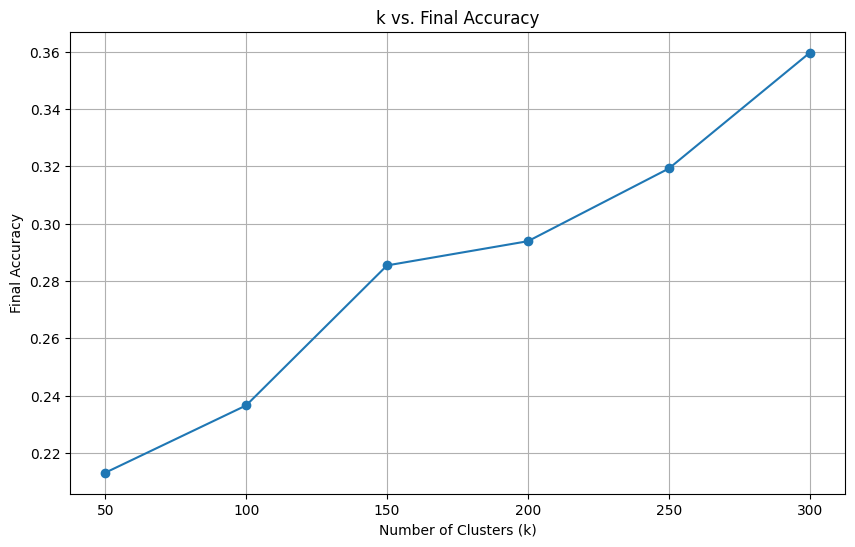

In [11]:
k_values = np.arange(50, 350, 50)
final_accuracies = []

for k in k_values:
    final_accuracy = kcluster_mlp(k, 20)
    final_accuracies.append(final_accuracy)
plt.figure(figsize=(10, 6))
plt.plot(k_values, final_accuracies, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Final Accuracy')
plt.title('k vs. Final Accuracy')
plt.grid(True)
plt.show()